In [1]:
# !pip install wandb --quiet # Install WandB
# !pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

In [2]:
# !pip install torchsummaryX==1.1.0 wandb --quiet
# !pip install torchsummary

In [3]:
import torch

#from torchsummary import summary

import torch.nn.functional as F
import matplotlib.pyplot as plt

import os

import gc

from tqdm import tqdm

import numpy as np

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn import metrics as mt

from scipy.optimize import brentq

from scipy.interpolate import interp1d

import glob

import wandb

import matplotlib.pyplot as plt

#from pytorch_metric_learning import samplers

import csv


# Import necessary libraries

import pandas as pd

import numpy as np

import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import seaborn as sns



from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.model_selection import train_test_split


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Device: ", DEVICE)


Device:  cuda


In [4]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

In [5]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"yuyunfrancis","key":"1372ee73bffdf954300c05ce2a98bb3e"}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [6]:
# # # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'

# !kaggle competitions download -c child-mind-institute-problematic-internet-use
# !unzip -qo 'child-mind-institute-problematic-internet-use.zip' -d '/content/data'

In [7]:
# Extract IDs from `parquet` files
def get_parquet_ids(data_directory):

    ids = set()
    for filename in os.listdir(data_directory):
        person_id = filename.split('=')[-1].split('.')[0]  # Extract ID from filename
        ids.add(person_id)
    return ids

# Load secondary dataset and filter based on available `parquet` IDs
def filter_secondary_data(secondary_dataset_path, parquet_ids):

    # Load secondary dataset
    secondary_df = pd.read_csv(secondary_dataset_path)

    # Filter rows to only those with IDs present in the parquet files
    filtered_df = secondary_df[secondary_df['id'].isin(parquet_ids)]

    # Create a dictionary mapping each ID to its `sii` value
    id_to_sii = pd.Series(filtered_df['sii'].values, index=filtered_df['id']).to_dict()
    return id_to_sii

gc.collect()

0

In [8]:
# Define paths and extract IDs
data_directory = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'  # Path to the directory with `parquet` files
secondary_dataset_path = '/kaggle/input/child-mind-institute-problematic-internet-use/train.csv'  # Path to the secondary dataset

# Get IDs from `parquet` files
parquet_ids = get_parquet_ids(data_directory)

# Filter the secondary dataset to match these IDs and create the label mapping
id_to_sii = filter_secondary_data(secondary_dataset_path, parquet_ids)
gc.collect()

0

In [9]:
secondary_view = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")

In [10]:
secondary_view.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
secondary_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")

In [12]:
secondary_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def preprocess_secondary_data(secondary_df, id_to_sii):
    """
    Preprocess secondary dataset to match IDs in the primary parquet data and handle missing values.

    Args:
    - secondary_df (pd.DataFrame): The secondary dataset as a pandas DataFrame.
    - id_to_sii (dict): Dictionary with parquet IDs as keys and labels as values.

    Returns:
    - processed_data (pd.DataFrame): Preprocessed secondary features aligned with primary dataset IDs.
    - labels (pd.Series): Labels corresponding to the filtered IDs in `processed_data`.
    """

    parquet_ids = set(id_to_sii.keys())
    filtered_df = secondary_df[secondary_df['id'].isin(parquet_ids)].copy()

    labels = filtered_df['sii'].fillna(-1)
    features = filtered_df.drop(columns=['id', 'sii'])

    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = features.select_dtypes(exclude=['object']).columns.tolist()

    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent for categorical
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),
            ('cat', cat_transformer, categorical_cols)
        ]
    )

    features_processed = preprocessor.fit_transform(features)
    processed_data = pd.DataFrame(features_processed, index=filtered_df.index)  # Keep the original index

    processed_data['id'] = filtered_df['id'].values

    return processed_data, labels.reset_index(drop=True)

process_secondary_data, labels = preprocess_secondary_data(secondary_df,id_to_sii)

In [14]:
process_secondary_data.shape

(996, 114)

In [15]:
class AccelerometerDataset(Dataset):
    def __init__(self, data_directory, sequence_length, features, label_dict, scaler=None, max_records=20000):
        self.data_directory = os.path.join(data_directory, "series_train.parquet")
        self.sequence_length = sequence_length
        self.features = features
        self.label_dict = label_dict
        self.scaler = scaler if scaler else StandardScaler()
        self.max_records = max_records
        self.data = []  # Store (person_id, sequence, label)

        # Load data for each ID directory and preprocess
        for directory in os.listdir(self.data_directory):
            if directory.startswith("id="):
                person_id = directory.split("=")[-1]  # Extract ID
                label = self.label_dict.get(person_id, -1)  # Get label based on ID

                if label == -1:
                    continue

                file_path = os.path.join(self.data_directory, directory, "part-0.parquet")
                if os.path.exists(file_path):
                    df = pd.read_parquet(file_path)
                    df = df.head(self.max_records)  # Limit records
                    df = self.preprocess(df)
                    sequences = self.create_sequences(df[self.features].values)

                    for seq in sequences:
                        self.data.append((person_id, seq, label))  # Include person_id as a string

    def preprocess(self, df):
        df = df.dropna(subset=self.features)
        df[self.features] = self.scaler.fit_transform(df[self.features])
        return df

    def create_sequences(self, data):
        sequences = []
        for i in range(0, len(data) - self.sequence_length + 1, self.sequence_length):
            sequence = data[i:i + self.sequence_length]
            sequences.append(sequence)
        return sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        person_id, sequence, label = self.data[idx]
        return person_id, torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [16]:
#Sanity check
data_directory = '/kaggle/input/child-mind-institute-problematic-internet-use'  # Root directory
sequence_length = 100
features = ['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light', 'battery_voltage', 'time_of_day', 'weekday', 'quarter', 'relative_date_PCIAT']
label_dict = id_to_sii
batch_size = 8

# Initialize the dataset and dataloader
dataset = AccelerometerDataset(data_directory, sequence_length, features, label_dict, max_records=20000)
# dataloader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)


In [17]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os

def merge_datasets(secondary_data, secondary_labels, accelerometer_dataset, sequence_length):
    """
    Merge preprocessed secondary data with the data from AccelerometerDataset.

    Args:
    - secondary_data (pd.DataFrame): Processed secondary data.
    - secondary_labels (pd.Series): Labels for secondary data.
    - accelerometer_dataset (AccelerometerDataset): Instance of the accelerometer dataset.
    - sequence_length (int): The sequence length for tensor sequences.
    Returns:
    - merged_dataset (list): List of tuples containing (id, combined_features, label).
    """
    # Convert secondary data to tensors
    secondary_tensors = torch.tensor(secondary_data.drop(columns=['id']).values, dtype=torch.float32)
    secondary_ids = secondary_data['id'].tolist()
    secondary_label_tensors = torch.tensor(secondary_labels.values, dtype=torch.long)

    # Mapping from ID to secondary data tensor
    id_to_secondary = {id_: (sec_tensor, label) for id_, sec_tensor, label in zip(secondary_ids, secondary_tensors, secondary_label_tensors)}

    # Merged dataset
    merged_dataset = []

    for idx in range(len(accelerometer_dataset)):
        person_id, acc_sequence, acc_label = accelerometer_dataset[idx]

        # Check if secondary data is available for the same ID
        if person_id in id_to_secondary:
            sec_tensor, sec_label = id_to_secondary[person_id]

            # Concatenate accelerometer sequence with secondary features
            sec_tensor_padded = torch.nn.functional.pad(sec_tensor, (0, acc_sequence.shape[1] - sec_tensor.shape[0]))
            combined_features = torch.cat((acc_sequence, sec_tensor_padded.unsqueeze(0)), dim=0)

            # Confirm the labels match
            if acc_label != sec_label:
                raise ValueError(f"Label mismatch for ID {person_id}: {acc_label} != {sec_label}")

            merged_dataset.append((person_id, combined_features, acc_label))
        else:
            # Optionally handle missing secondary data (e.g., pad with zeros or skip)
            sec_tensor_padded = torch.zeros(1, acc_sequence.shape[1])
            combined_features = torch.cat((acc_sequence, sec_tensor_padded.unsqueeze(0)), dim=0)
            merged_dataset.append((person_id, combined_features, acc_label))

    return merged_dataset



# Preprocess secondary data
secondary_data, secondary_labels = preprocess_secondary_data(secondary_df, id_to_sii)

# Initialize AccelerometerDataset
accelerometer_dataset = AccelerometerDataset(data_directory, sequence_length, features, label_dict)

# Merge datasets
merged_dataset = merge_datasets(secondary_data, secondary_labels, accelerometer_dataset, sequence_length)

dataloader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)

In [18]:

import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Encoder(nn.Module):
    def _init_(self, input_size, hidden_size, latent_dim, num_layers=4, n_heads=4, dropout=0.1):
        super(Encoder, self)._init_()

        # Existing layers
        self.positional_encoding = PositionalEncoding(input_size, dropout)
        self.transformer_layer = TransformerEncoderLayer(
            d_model=input_size, nhead=n_heads, dim_feedforward=hidden_size * 2,
            dropout=dropout, activation="gelu", batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.transformer_layer, num_layers)
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1)
        self.fc_project = nn.Linear(hidden_size * 2, input_size)
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers // 2,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        self.multi_head_attention = MultiHeadAttention(hidden_size * 2, n_heads)

        # New projection layer for attention output
        self.attention_projection = nn.Linear(hidden_size * 2, hidden_size)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_dim)

        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Positional Encoding
        x = self.positional_encoding(x)
    
        # Transformer Encoder
        x = self.transformer_encoder(x)
    
        # Convolutional Layers
        x = x.transpose(1, 2)  # (Batch, Seq_len, Channels) -> (Batch, Channels, Seq_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.transpose(1, 2)  # (Batch, Channels, Seq_len) -> (Batch, Seq_len, Channels)
    
        # Project back to input_size for LSTM
        x = self.fc_project(x)
    
        # Bidirectional LSTM
        rnn_output, _ = self.rnn(x)
        rnn_output = self.layer_norm(rnn_output)
    
        # Multi-head Attention
        attention_output = self.multi_head_attention(rnn_output, rnn_output, rnn_output)
    
        # Reduce attention output size
        attention_reduced = self.attention_projection(attention_output[:, -1, :])
    
        # Align dimensions with projection layer
        residual = self.fc1(attention_reduced)
    
        # Combine with residual connection
        latent = self.fc2(F.relu(residual + attention_reduced))
    
        return latent


class PositionalEncoding(nn.Module):
    """
    Positional Encoding for Transformer models to introduce sequence order.
    """
    def _init_(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self)._init_()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention with learned projections for Q, K, and V.
    """
    def _init_(self, embed_dim, num_heads):
        super(MultiHeadAttention, self)._init_()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads

        assert (
            self.head_dim * num_heads == embed_dim
        ), "embed_dim must be divisible by num_heads"

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        # Linear projections
        Q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)
        attention_output = torch.matmul(attention_weights, V)

        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        # Final linear projection
        return self.out_proj(attention_output)

In [19]:
def get_encoded_values(encoder, dataloader, device):
    """
    Extracts encoded latent values from the Encoder for each person in the dataloader.

    Parameters:
        encoder (nn.Module): The complex Encoder model.
        dataloader (DataLoader): Dataloader providing person_ids, sequences, and labels.
        device (torch.device): Device to run the computation on (CPU or GPU).

    Returns:
        dict: Averaged latent values for each person_id.
    """
    encoder.eval()
    encoded_values = {}

    with torch.no_grad():
        for person_ids, sequences, labels in dataloader:
            sequences = sequences.to(device)

            # Forward pass through the complex encoder
            latent = encoder(sequences)  # Encoded latent representation

            # Aggregate latent vectors for each person_id
            for i, latent_value in enumerate(latent):
                # Handle different types for person_ids
                if isinstance(person_ids[i], torch.Tensor):
                    person_id = person_ids[i].item()  # Convert tensor to int/float
                else:
                    person_id = person_ids[i]  # Use directly if not a tensor

                if person_id not in encoded_values:
                    encoded_values[person_id] = []
                encoded_values[person_id].append(latent_value.cpu().numpy())

    # Optionally, average the latent vectors for each person_id
    averaged_encoded_values = {
        person_id: np.mean(values, axis=0) for person_id, values in encoded_values.items()
    }

    return averaged_encoded_values

In [20]:


class PositionalEncoding(nn.Module):
    """
    Positional Encoding for Transformer models to introduce sequence order.
    Automatically adjusts for odd d_model values.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Ensure d_model is even
        if d_model % 2 != 0:
            print(f"Warning: d_model ({d_model}) is not even. Adjusting to {d_model + 1}.")
            d_model += 1

        self.dropout = nn.Dropout(p=dropout)

        # Compute positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)
        Q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)
        attention_output = torch.matmul(attention_weights, V)
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        return self.out_proj(attention_output)


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_layers=4, n_heads=4, dropout=0.1):
        super(Encoder, self).__init__()
        
        # Ensure input_size is divisible by n_heads
        if input_size % n_heads != 0:
            print(f"Warning: input_size ({input_size}) is not divisible by n_heads ({n_heads}). Adjusting to {input_size + (n_heads - input_size % n_heads)}.")
            input_size += (n_heads - input_size % n_heads)
        
        self.positional_encoding = PositionalEncoding(input_size, dropout)
        
        # Transformer layers
        self.transformer_layer = TransformerEncoderLayer(
            d_model=input_size,
            nhead=n_heads,
            dim_feedforward=hidden_size * 2,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        
        self.transformer_encoder = TransformerEncoder(self.transformer_layer, num_layers)

        # Convolutional layers
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1)

        # Fully connected projection layer
        self.fc_project = nn.Linear(hidden_size * 2, input_size)

        # Recurrent layer (LSTM)
        self.rnn = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers // 2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Multi-head attention and projections
        self.multi_head_attention = MultiHeadAttention(hidden_size * 2, n_heads)
        self.attention_projection = nn.Linear(hidden_size * 2, hidden_size)

        # Fully connected layers for latent space projection
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_dim)

        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        # Positional encoding and transformer encoder
        x = self.positional_encoding(x)  
        
        x = self.transformer_encoder(x) 
        
        # Convolutional layers (reshape for Conv1D compatibility)
        x = x.transpose(1, 2)  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = x.transpose(1, 2)  
        
        x = self.fc_project(x) 
        
        rnn_output, _ = self.rnn(x)  
        
        rnn_output = self.layer_norm(rnn_output)  
        
        attention_output = self.multi_head_attention(rnn_output, rnn_output, rnn_output)  
        
        attention_reduced = self.attention_projection(attention_output[:, -1, :])  
        
        residual = self.fc1(attention_reduced) 
        
        latent = self.fc2(F.relu(residual + attention_reduced)) 
        
        return latent 

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 15  # Adjust to the actual size of 'features'
hidden_size = 128
latent_dim = 64
num_layers = 4

encoder = Encoder(input_size, hidden_size, latent_dim, num_layers).to(device)



In [21]:
 
def get_encoded_values(encoder, dataloader, device):
    """
    Extracts encoded latent values from the Encoder for each person in the dataloader.

    Parameters:
        encoder (nn.Module): The complex Encoder model.
        dataloader (DataLoader): Dataloader providing person_ids, sequences, and labels.
        device (torch.device): Device to run the computation on (CPU or GPU).

    Returns:
        dict: Averaged latent values for each person_id.
    """
    encoder.eval()
    encoded_values = {}

    with torch.no_grad():
        for person_ids, sequences, labels in dataloader:
            sequences = sequences.to(device)

            # Forward pass through the complex encoder
            latent = encoder(sequences)  # Encoded latent representation

            # Aggregate latent vectors for each person_id
            for i, latent_value in enumerate(latent):
                # Handle different types for person_ids
                if isinstance(person_ids[i], torch.Tensor):
                    person_id = person_ids[i].item()  # Convert tensor to int/float
                else:
                    person_id = person_ids[i]  # Use directly if not a tensor

                if person_id not in encoded_values:
                    encoded_values[person_id] = []
                encoded_values[person_id].append(latent_value.cpu().numpy())

    # Optionally, average the latent vectors for each person_id
    averaged_encoded_values = {
        person_id: np.mean(values, axis=0) for person_id, values in encoded_values.items()
    }

    return averaged_encoded_values

In [22]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = len(features)  # Number of features in the time-series data
hidden_size = 128
latent_dim = 64
num_layers = 2

encoder = Encoder(input_size, hidden_size, latent_dim, num_layers).to(device)

encoded_values = get_encoded_values(encoder, dataloader, device)


secondary_df = process_secondary_data.copy()
encoded_df = pd.DataFrame.from_dict(encoded_values, orient='index', columns=[f'latent_{i}' for i in range(latent_dim)])
encoded_df.reset_index(inplace=True)
encoded_df.rename(columns={'index': 'id'}, inplace=True)

combined_data = secondary_df.merge(encoded_df, on='id', how='inner')

#Add the labels
id_to_label_series = pd.Series(id_to_sii)
combined_data['label'] = combined_data['id'].map(id_to_label_series)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:

class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        # Separate features and labels from combined_data
        self.features = combined_data.drop(columns=['id', 'label']).values.astype(np.float32)  # Exclude 'id' and 'label'
        self.labels = combined_data['label'].values.astype(np.int64)  # Directly extract the 'label' column

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [52]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, use_residual=True):
        """
        A deeper version of the SimpleClassifier with residual connections.
        """
        super(SimpleClassifier, self).__init__()
        self.use_residual = use_residual

        # Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        # Projection for residual connections (if needed)
        self.residual_proj1 = nn.Linear(input_dim, hidden_dim) if use_residual else None
        self.residual_proj2 = nn.Linear(hidden_dim, hidden_dim // 2) if use_residual else None

        # Activation and dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # First layer
        residual1 = x
        x = self.activation(self.fc1(x))
        x = self.dropout(x)

        if self.use_residual:
            if residual1.size(1) != x.size(1):  # Align dimensions for addition
                residual1 = self.residual_proj1(residual1)
            x += residual1  # Add residual

        # Second layer
        residual2 = x
        x = self.activation(self.fc2(x))
        x = self.dropout(x)

        if self.use_residual:
            if residual2.size(1) != x.size(1):  # Align dimensions for addition
                residual2 = self.residual_proj2(residual2)
            x += residual2  # Add residual

        # Output layer
        x = self.fc3(x)
        return x


In [53]:
#Evaluation metric
from sklearn.metrics import confusion_matrix

def quadratic_weighted_kappa(y_true, y_pred, N):
    """
    Compute the quadratic weighted kappa metric.

    Args:
        y_true (np.array): Array of true labels.
        y_pred (np.array): Array of predicted labels.
        N (int): Number of distinct labels.

    Returns:
        float: Quadratic weighted kappa score.
    """
    O = confusion_matrix(y_true, y_pred, labels=range(N))
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            W[i, j] = ((i - j) ** 2) / ((N - 1) ** 2)

    true_hist = np.histogram(y_true, bins=np.arange(N+1))[0]
    pred_hist = np.histogram(y_pred, bins=np.arange(N+1))[0]

    E = np.outer(true_hist, pred_hist)
    E = E / E.sum() * O.sum()

    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    kappa = 1 - numerator / denominator

    return kappa

In [54]:
#Prepare dataloader and model parameters
dataset = CombinedDataset(combined_data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Initialize model parameters
input_dim = combined_data.shape[1] - 2  
hidden_dim = 128
output_dim = len(combined_data['label'].unique())  # Number of unique labels

model = SimpleClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
# from torchsummary import summary

# Move model to the correct device
model = model.to(device)

# Get a batch from the train_loader
data_iter = iter(train_loader)
x_batch, y_batch = next(data_iter)

# Make sure the batch is on the correct device
x_batch = x_batch.to(device)

# Get the model summary using the shape of the input data
# summary(
#     model,
#     input_size=(x_batch.size(1),)  # Pass the input size as a tuple (features,)
# )


In [56]:
num_epochs = 10
best_qwk = 0.0
best_epoch = 0
train_losses = []
val_losses = []
accuracies = []
qwk_scores = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Get predictions and accumulate results for QWK
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    qwk_score = quadratic_weighted_kappa(np.array(all_labels), np.array(all_preds), N=output_dim)

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    accuracies.append(val_accuracy)
    qwk_scores.append(qwk_score)

    # Save best model
    if qwk_score > best_qwk:
        best_qwk = qwk_score
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"QWK Score: {qwk_score:.4f}")
    print("-" * 50)

    # Early stopping (optional)
    # if epoch - best_epoch > 10:  # If no improvement for 10 epochs
    #     print("Early stopping triggered")
    #     break


Epoch 1/10
Train Loss: 0.4913, Train Accuracy: 81.41%
Val Loss: 0.2766, Val Accuracy: 94.00%
QWK Score: 0.9481
--------------------------------------------------
Epoch 2/10
Train Loss: 0.1572, Train Accuracy: 95.73%
Val Loss: 0.2428, Val Accuracy: 93.50%
QWK Score: 0.9445
--------------------------------------------------
Epoch 3/10
Train Loss: 0.1026, Train Accuracy: 96.73%
Val Loss: 0.1765, Val Accuracy: 94.00%
QWK Score: 0.9515
--------------------------------------------------
Epoch 4/10
Train Loss: 0.0733, Train Accuracy: 98.37%
Val Loss: 0.2273, Val Accuracy: 92.50%
QWK Score: 0.9353
--------------------------------------------------
Epoch 5/10
Train Loss: 0.0586, Train Accuracy: 98.37%
Val Loss: 0.2969, Val Accuracy: 92.00%
QWK Score: 0.9272
--------------------------------------------------
Epoch 6/10
Train Loss: 0.0426, Train Accuracy: 98.74%
Val Loss: 0.2540, Val Accuracy: 93.50%
QWK Score: 0.9421
--------------------------------------------------
Epoch 7/10
Train Loss: 0.048

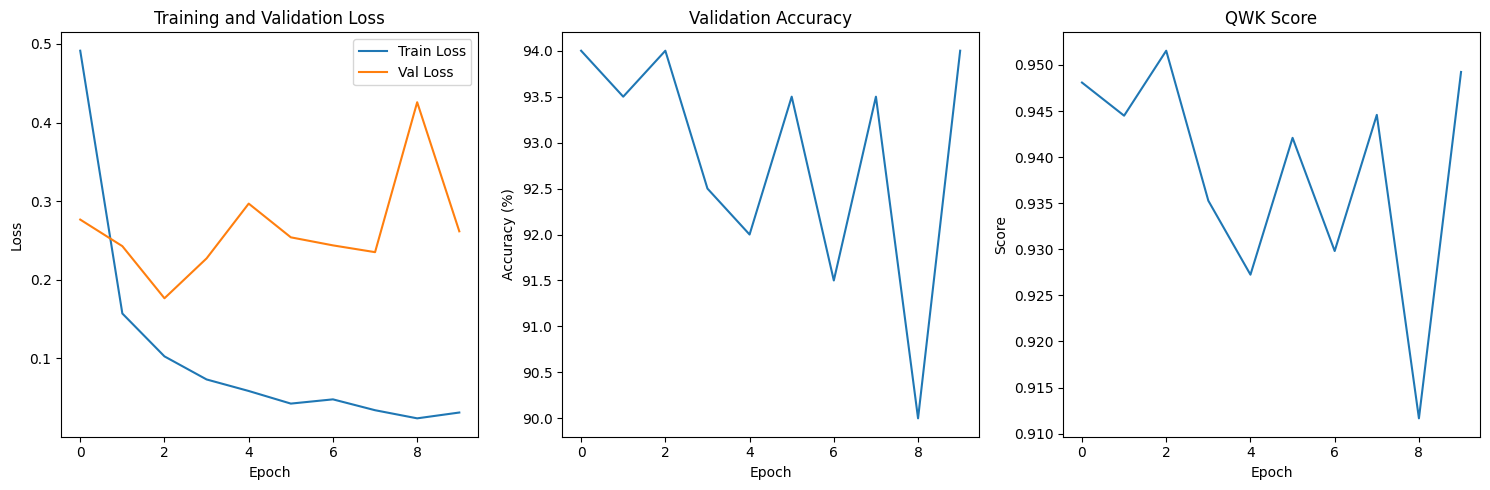

Best QWK Score: 0.9515 at epoch 3


In [57]:

# Plot training metrics
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# QWK plot
plt.subplot(1, 3, 3)
plt.plot(qwk_scores)
plt.title('QWK Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

print(f"Best QWK Score: {best_qwk:.4f} at epoch {best_epoch + 1}")

In [58]:
#Preparing data for testing

def preprocess_secondary_test_data(secondary_df):
    # Separate features and IDs
    features = secondary_df.drop(columns=['id'])
    ids = secondary_df['id']

    # Define preprocessing pipelines for numeric and categorical data
    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = features.select_dtypes(exclude=['object']).columns.tolist()

    # Impute and scale numeric features
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute with mean for numeric
        ('scaler', StandardScaler())  # Standardize numeric features
    ])

    # Impute and encode categorical features
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent for categorical
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),
            ('cat', cat_transformer, categorical_cols)
        ]
    )

    # Fit and transform the features
    features_processed = preprocessor.fit_transform(features)
    processed_data = pd.DataFrame(features_processed)

    # Add the 'id' column back to maintain alignment
    processed_data['id'] = ids.values

    return processed_data

# Usage Example
secondary_test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')  # Update with actual path

# Preprocess the test data without dropping any rows
processed_secondary_test_data = preprocess_secondary_test_data(secondary_test_df)

In [59]:
processed_secondary_test_data.shape

(20, 84)

In [60]:
# test_features = processed_secondary_test_data.drop(columns=['id']).values.astype(np.float32)
test_ids = processed_secondary_test_data['id']
processed_secondary_test =processed_secondary_test_data.drop(columns = 'id')

In [61]:
test_ids

0     00008ff9
1     000fd460
2     00105258
3     00115b9f
4     0016bb22
5     001f3379
6     0038ba98
7     0068a485
8     0069fbed
9     0083e397
10    0087dd65
11    00abe655
12    00ae59c9
13    00af6387
14    00bd4359
15    00c0cd71
16    00d56d4b
17    00d9913d
18    00e6167c
19    00ebc35d
Name: id, dtype: object

In [62]:

def match_feature_dimension(train_features, test_features):
    train_dim = train_features.shape[1]
    test_dim = test_features.shape[1]

    if test_dim != train_dim:
        if test_dim < train_dim:
            # Padding test features to match train feature dimension
            padding = train_dim - test_dim
            test_features = np.pad(test_features, ((0, 0), (0, padding)), 'constant')
        else:
            # Truncating test features to match train feature dimension
            test_features = test_features[:, :train_dim]

    return test_features

train_features = combined_data.drop(columns=['id', 'label']).values.astype(np.float32)

# Example usage:
# Convert `processed_secondary_test_data` to NumPy if it's a tensor
processed_secondary_test_data = (
    processed_secondary_test_data.cpu().numpy() if isinstance(processed_secondary_test_data, torch.Tensor) else processed_secondary_test_data
)

test_features_corrected = match_feature_dimension(train_features, processed_secondary_test)



In [63]:
test_features_corrected

# np.isreal checks if each element is a real number
is_numeric = np.isreal(test_features_corrected)

# Find the indices of non-numeric values
non_numeric_indices = np.argwhere(~is_numeric)

if non_numeric_indices.size > 0:
    print("Indices of non-numeric values:", non_numeric_indices)
else:
    print("All elements are numeric.")


All elements are numeric.


In [64]:
class NonSeriesTestDataset(Dataset):
    def __init__(self, features, ids):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.ids = ids

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        id_ = self.ids.iloc[idx] if hasattr(self.ids, 'iloc') else self.ids[idx]
        return x, id_

In [65]:
from torch.utils.data import DataLoader

# Create an instance of your custom dataset
test_dataset = NonSeriesTestDataset(features=test_features_corrected, ids= test_ids)  # `ids` should be your list of ids.

# Pass the dataset to DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Proceed with evaluation as before
model.eval()  # Set model to evaluation mode
test_preds = []
test_ids = []

with torch.no_grad():
    for features, ids in test_loader:
        features = features.to(device)

        # Get predictions
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and ids for each batch
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend(ids)  # Assuming `ids` is directly from test_loader and matches row order

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'sii': test_preds
})

# Save to CSV for submission
submission_df.to_csv("submission.csv", index=False)
